## Load Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

# Regression Modeling

In [3]:
taxi = pd.read_csv("taxi_clean_for_modeling.csv")

### Keep Columns only used for modeling

In [ ]:
# Feature Columns for Regression
feature_cols_reg = ["pickup_zone", "airport", "hour", "day_of_week", "trip_distance", "payment_type"]

### Train/Test Split and Set Targets

In [ ]:
from sklearn.model_selection import train_test_split

# Sort by pickup datetime
taxi = taxi.sort_values("tpep_pickup_datetime")

# Split into train/test
split_idx = int(0.8 * len(taxi))
train = taxi.iloc[:split_idx].copy()
test = taxi.iloc[split_idx:].copy()

# Feature Columns for Regression
X_train_reg = train[feature_cols_reg]
X_test_reg  = test[feature_cols_reg]
y_reg_train = train["duration_min"]
y_reg_test  = test["duration_min"]


### Baseline Model: Regression

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def reg_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

# Baseline: predict training median
train_median = y_reg_train.median()
y_reg_pred_baseline = np.full_like(y_reg_test, fill_value=train_median, dtype=float)

mae_baseline = mean_absolute_error(y_reg_test, y_reg_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_baseline))

print("Baseline (train median) MAE :", mae_baseline)
print("Baseline (train median) RMSE:", rmse_baseline)



Baseline (train median) MAE : 13.062379800423344
Baseline (train median) RMSE: 16.31660814602682


### Encoding/Preprocessing

Before any of our model sees our data, we are taking the columns below and leaving the numerical columns as it and turning the categorical text/ID columns into dummy variables using one-hot encoding. Models can not directly work with IDs like JFK, or some categorical data, so we convert to dummy variables.

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

numeric_features = ["trip_distance", "hour", "day_of_week"]
categorical_features = ["pickup_zone", "airport", "payment_type"]

preprocessor = ColumnTransformer(transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ])

## Regression Models

### XGBoost Regression Model

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Create Model
xgb_reg = XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1)

# Create Pipeline
reg_pipe = Pipeline(steps=[
    ("pre", preprocessor),
    ("model", xgb_reg),])

# Create Hyperparameter Grid + Search
param_grid_reg = {
    "model__n_estimators": [100,200,400,500],    # Number of trees
    "model__max_depth": [3, 5, 7, 10],           # Depth of each tree
    "model__learning_rate": [0.1, 0.05, 0.01],   # Learning rate
    "model__subsample": [0.8, 1.0, 0.5],         # Fraction of samples used for each tree
}

# Grid Search
grid_reg = GridSearchCV(
    estimator=reg_pipe,                   # Whole pipeline
    param_grid=param_grid_reg,            # Hyperparameter grid
    cv=3,                                 # 3-fold cross validation
    scoring="neg_mean_absolute_error",    # Scoring metric
    n_jobs=-1,                            # Use all available CPU cores
    verbose=1,                            # Print progress
)

# Fit Model
grid_reg.fit(X_train_reg, y_reg_train)
print("Best params (regression):", grid_reg.best_params_)
print("Best CV MAE:", -grid_reg.best_score_)

# Rename for clarity
best_xgb_reg = grid_reg.best_estimator_

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best params (regression): {'model__learning_rate': 0.05, 'model__max_depth': 7, 'model__n_estimators': 400, 'model__subsample': 0.8}
Best CV MAE: 5.52327313587696


##### Evaluate the XGBoost Model

In [ ]:
# Train predictions 
y_pred_train_reg = best_xgb_reg.predict(X_train_reg)         
mae_train = mean_absolute_error(y_reg_train, y_pred_train_reg)
mse_train = mean_squared_error(y_reg_train, y_pred_train_reg)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_reg_train, y_pred_train_reg)

# Test predictions 
y_pred_test_reg = best_xgb_reg.predict(X_test_reg)
mae_test = mean_absolute_error(y_reg_test, y_pred_test_reg)
mse_test = mean_squared_error(y_reg_test, y_pred_test_reg)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_reg_test, y_pred_test_reg)

print("\nTuned XGBoost Regression — Train vs Test")
print(f"Train MAE : {mae_train: .3f}")
print(f"Test  MAE : {mae_test: .3f}")
print(f"Train RMSE: {rmse_train: .3f}")
print(f"Test  RMSE: {rmse_test: .3f}")
print(f"Train R²  : {r2_train: .3f}")
print(f"Test  R²  : {r2_test: .3f}")


Tuned XGBoost Regression — Train vs Test
Train MAE :  4.520
Test  MAE :  5.605
Train RMSE:  6.407
Test  RMSE:  7.659
Train R²  :  0.870
Test  R²  :  0.773


### Visualize the XGBoost Learning Curve

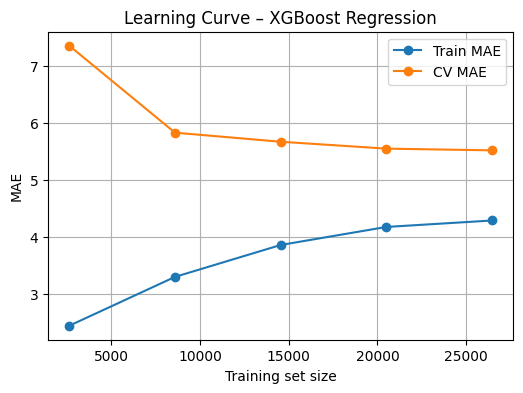

In [ ]:
from sklearn.model_selection import learning_curve


train_sizes, train_scores, val_scores = learning_curve(
    best_xgb_reg,
    X_train_reg,
    y_reg_train,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
)

train_mae = -train_scores.mean(axis=1)
val_mae   = -val_scores.mean(axis=1)

# plot
plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mae, marker="o", label="Train MAE")
plt.plot(train_sizes, val_mae, marker="o", label="CV MAE")
plt.xlabel("Training set size")
plt.ylabel("MAE")
plt.title("Learning Curve – XGBoost Regression")
plt.legend()
plt.grid(True)
plt.show()

As we increase the training set size, the training MAE rises and the cross-validated MAE falls, and the two curves converge around 5–6 minutes. This means XGBoost benefits from more data and generalizes better as we feed it more trips. By the largest training size, the gap between train and validation error is modest, suggesting only mild overfitting and good generalization. The validation MAE also levels off around 5.5 minutes, close to our held out test MAE, indicating that we are near the performance ceiling for this feature set.

### XGBoost Residuals / Predicted vs Actual

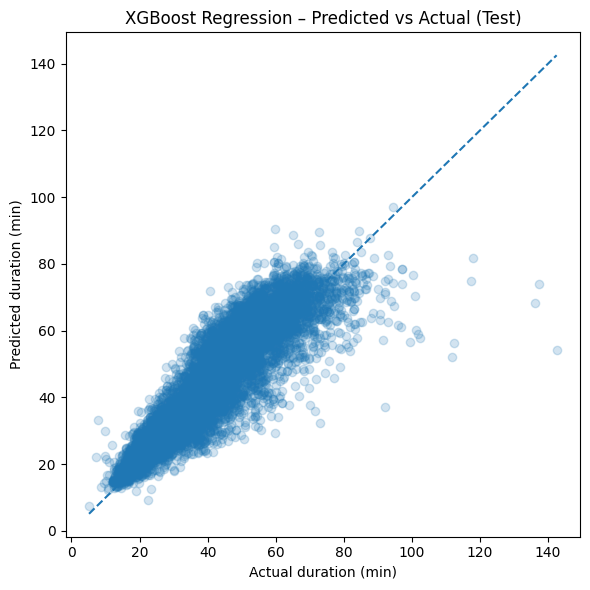

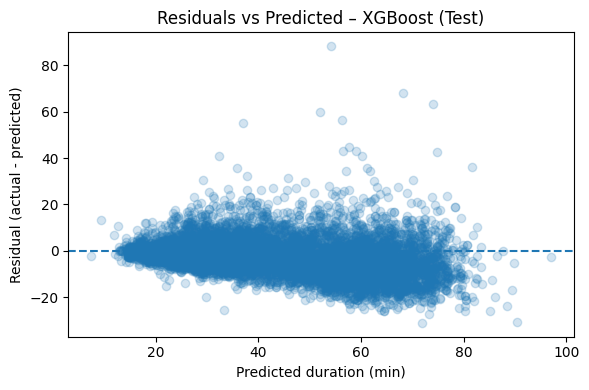

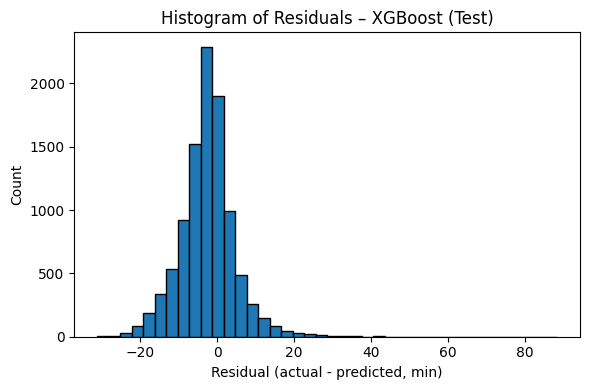

In [ ]:
# Predictions on test set (pipeline applies encoding internally)
y_pred_test_reg = best_xgb_reg.predict(X_test_reg)

# Residuals: actual - predicted
residuals = y_reg_test - y_pred_test_reg
abs_errors = np.abs(residuals)

# Predicted vs Actual
plt.figure(figsize=(6, 6))
plt.scatter(y_reg_test, y_pred_test_reg, alpha=0.2)
plt.plot([y_reg_test.min(), y_reg_test.max()],
         [y_reg_test.min(), y_reg_test.max()],
         linestyle="--")
plt.xlabel("Actual duration (min)")
plt.ylabel("Predicted duration (min)")
plt.title("XGBoost Regression – Predicted vs Actual (Test)")
plt.tight_layout()
plt.show()

# Residuals vs Predicted
plt.figure(figsize=(6, 4))
plt.scatter(y_pred_test_reg, residuals, alpha=0.2)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted duration (min)")
plt.ylabel("Residual (actual - predicted)")
plt.title("Residuals vs Predicted – XGBoost (Test)")
plt.tight_layout()
plt.show()

# Residual Distribution
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=40, edgecolor="k")
plt.xlabel("Residual (actual - predicted, min)")
plt.ylabel("Count")
plt.title("Histogram of Residuals – XGBoost (Test)")
plt.tight_layout()
plt.show()

### XGBoost Feature Importance

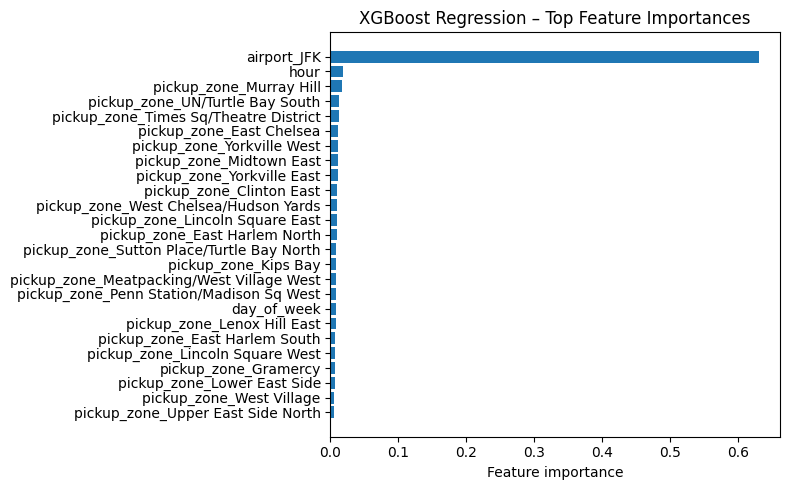

In [ ]:
# Get feature names from preprocessor
ohe = best_xgb_reg.named_steps["pre"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features, cat_feature_names])

# Importances from XGB model
importances = best_xgb_reg.named_steps["model"].feature_importances_

k = 25
idx_sorted = np.argsort(importances)[::-1][:k]
top_feats = feature_names[idx_sorted]
top_imps  = importances[idx_sorted]

plt.figure(figsize=(8, 5))
plt.barh(range(len(top_feats)), top_imps)
plt.yticks(range(len(top_feats)), top_feats)
plt.gca().invert_yaxis()
plt.xlabel("Feature importance")
plt.title("XGBoost Regression – Top Feature Importances")
plt.tight_layout()
plt.show()

### AdaBoost

In [17]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# Create AdaBoostRegressor Model (base_estimator param is deprecated in >=0.24, use estimator instead)
ada_reg = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=3),  # basic weak learner, tunable
    random_state=42
)

# Create Pipeline
ada_reg_pipe = Pipeline([
    ("pre", preprocessor),          
    ("model", ada_reg)
])

# Create Expanded Hyperparameter Grid for AdaBoost
param_grid_ada = {
    "model__n_estimators": [50, 100],                           # more estimators
    "model__learning_rate": [1.0, 0.5, 0.1, 0.05],                   # common rates
    "model__estimator__max_depth": [1, 2, 3, 5],                     # weak learner complexity
    "model__estimator__min_samples_split": [2, 5, 10],               # min samples to split node
    "model__estimator__min_samples_leaf": [1, 2, 4]                  # min samples at leaf
}

# Grid Search for AdaBoost Regressor
grid_ada = GridSearchCV(
    estimator=ada_reg_pipe,
    param_grid=param_grid_ada,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1,
)

# Fit Model
grid_ada.fit(X_train_reg, y_reg_train)
print("Best params (AdaBoost regression):", grid_ada.best_params_)
print("Best CV MAE:", -grid_ada.best_score_)

# Rename for clarity
best_ada_reg = grid_ada.best_estimator_

# Predictions
y_pred_ada_train = best_ada_reg.predict(X_train_reg)
y_pred_ada_test  = best_ada_reg.predict(X_test_reg)

# Metrics
mae_tr_ada, rmse_tr_ada, r2_tr_ada = reg_metrics(y_reg_train, y_pred_ada_train)
mae_te_ada, rmse_te_ada, r2_te_ada = reg_metrics(y_reg_test,  y_pred_ada_test)

print("AdaBoost Regression — Train vs Test")
print(f"Train MAE : {mae_tr_ada: .3f}")
print(f"Test  MAE : {mae_te_ada: .3f}")
print(f"Train RMSE: {rmse_tr_ada: .3f}")
print(f"Test  RMSE: {rmse_te_ada: .3f}")
print(f"Train R²  : {r2_tr_ada: .3f}")
print(f"Test  R²  : {r2_te_ada: .3f}")

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Best params (AdaBoost regression): {'model__estimator__max_depth': 5, 'model__estimator__min_samples_leaf': 1, 'model__estimator__min_samples_split': 10, 'model__learning_rate': 0.05, 'model__n_estimators': 50}
Best CV MAE: 6.9011445819126065
AdaBoost Regression — Train vs Test
Train MAE :  6.723
Test  MAE :  6.873
Train RMSE:  9.181
Test  RMSE:  9.060
Train R²  :  0.733
Test  R²  :  0.682


### AdaBoost Plots

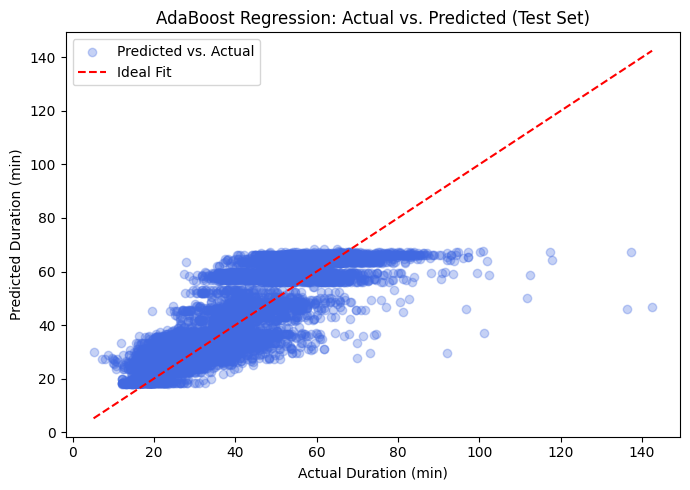

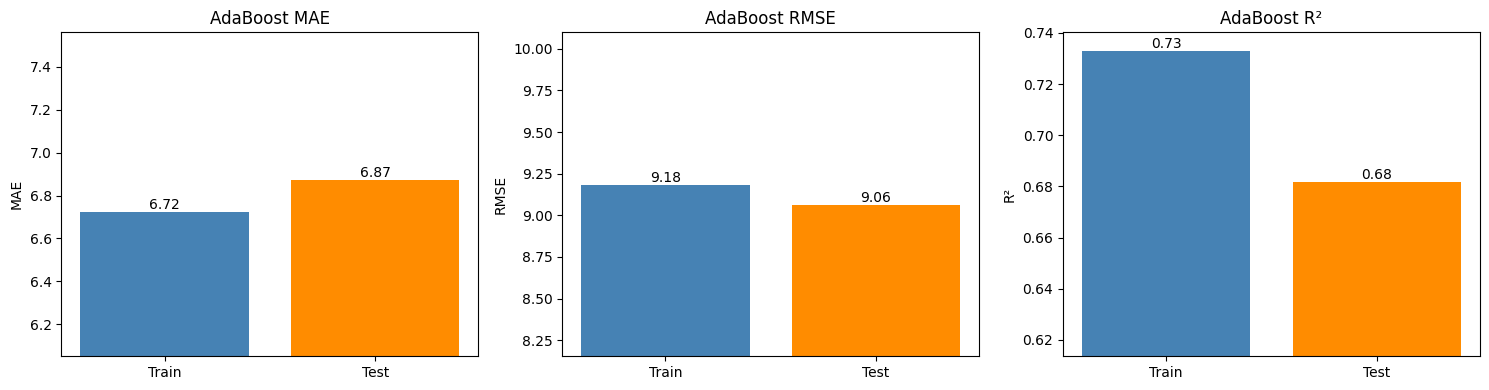

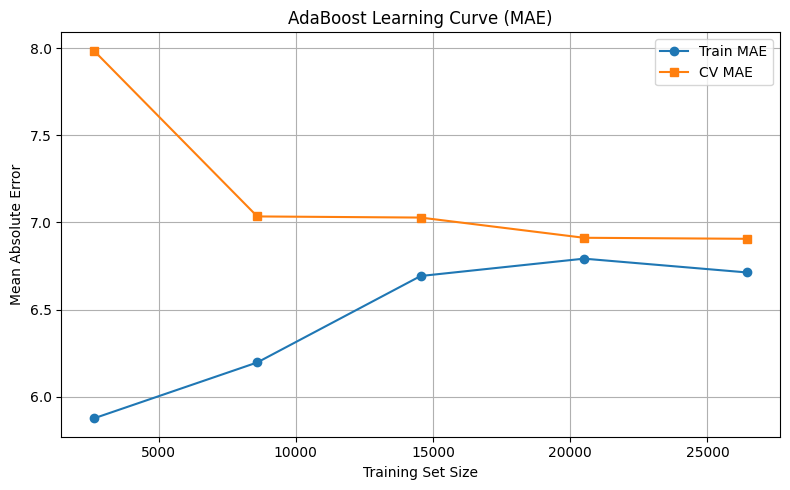

In [ ]:
# Plotting Actual vs Predicted for AdaBoost Regression (Test set)
plt.figure(figsize=(7,5))
plt.scatter(y_reg_test, y_pred_ada_test, alpha=0.3, label="Predicted vs. Actual", color='royalblue')
plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--', label='Ideal Fit')
plt.xlabel('Actual Duration (min)')
plt.ylabel('Predicted Duration (min)')
plt.title('AdaBoost Regression: Actual vs. Predicted (Test Set)')
plt.legend()
plt.tight_layout()
plt.show()

# Bar chart summary of key metrics (Train vs Test) for AdaBoost
ada_metrics = {
    "MAE": [mae_tr_ada, mae_te_ada],
    "RMSE": [rmse_tr_ada, rmse_te_ada],
    "R²": [r2_tr_ada, r2_te_ada],
}
labels = ["Train", "Test"]

fig, axs = plt.subplots(1, 3, figsize=(15,4))
cols = list(ada_metrics.keys())
for i, metric in enumerate(cols):
    axs[i].bar(labels, ada_metrics[metric], color=['steelblue', 'darkorange'])
    axs[i].set_title(f"AdaBoost {metric}")
    axs[i].set_ylim(
        min(ada_metrics[metric]) * 0.9,
        max(ada_metrics[metric]) * (1.1 if metric != 'R²' else 1.01)
    )
    axs[i].set_ylabel(metric)
    for idx, val in enumerate(ada_metrics[metric]):
        axs[i].text(idx, val, f"{val:.2f}", ha="center", va="bottom", fontsize=10, color="black")
plt.tight_layout()
plt.show()

# Track learning curves (optionally)
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_ada_reg, X_train_reg, y_reg_train, cv=3,
    scoring="neg_mean_absolute_error", train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)
train_mae = -train_scores.mean(axis=1)
val_mae = -val_scores.mean(axis=1)
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mae, marker='o', label='Train MAE')
plt.plot(train_sizes, val_mae, marker='s', label='CV MAE')
plt.xlabel("Training Set Size")
plt.ylabel("Mean Absolute Error")
plt.title("AdaBoost Learning Curve (MAE)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## Linear Regression Model

In [ ]:
from sklearn.linear_model import LinearRegression

# Linear Regression pipeline
lin_reg_pipe = Pipeline([
    ("pre", preprocessor),          
    ("model", LinearRegression())
])

lin_reg_pipe.fit(X_train_reg, y_reg_train)

# Predictions
y_pred_lin_train = lin_reg_pipe.predict(X_train_reg)
y_pred_lin_test  = lin_reg_pipe.predict(X_test_reg)

# Metrics
def reg_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

mae_tr_lin, rmse_tr_lin, r2_tr_lin = reg_metrics(y_reg_train, y_pred_lin_train)
mae_te_lin, rmse_te_lin, r2_te_lin = reg_metrics(y_reg_test,  y_pred_lin_test)

print("Linear Regression — Train vs Test")
print(f"Train MAE : {mae_tr_lin: .3f}")
print(f"Test  MAE : {mae_te_lin: .3f}")
print(f"Train RMSE: {rmse_tr_lin: .3f}")
print(f"Test  RMSE: {rmse_te_lin: .3f}")
print(f"Train R²  : {r2_tr_lin: .3f}")
print(f"Test  R²  : {r2_te_lin: .3f}")


Linear Regression — Train vs Test
Train MAE :  7.472
Test  MAE :  6.619
Train RMSE:  10.517
Test  RMSE:  9.086
Train R²  :  0.649
Test  R²  :  0.680


### Linear Regression Error Plots

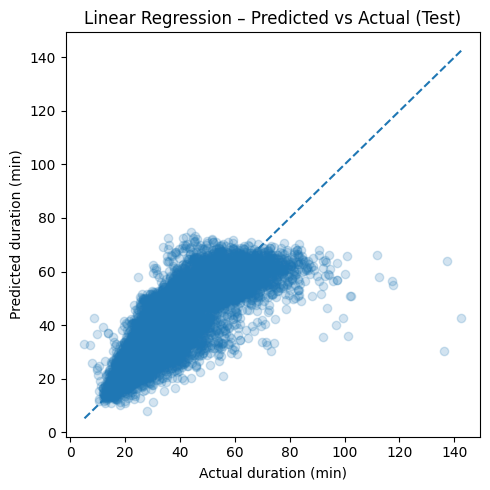

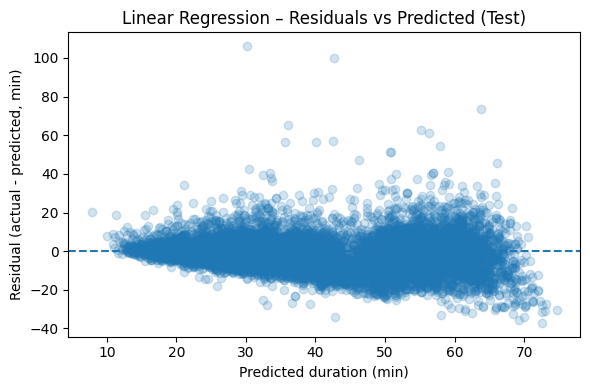

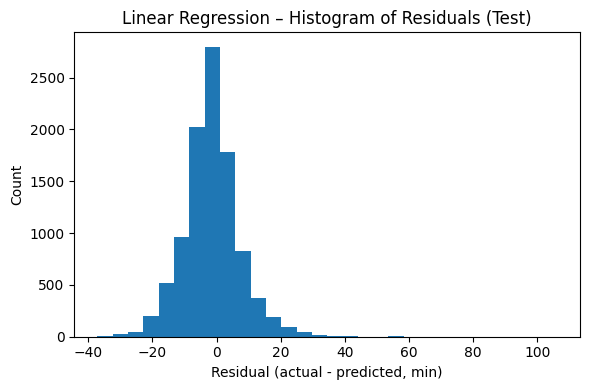

In [21]:
def plot_pred_vs_actual(y_true, y_pred, title):
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, alpha=0.2)
    max_val = max(y_true.max(), y_pred.max())
    min_val = min(y_true.min(), y_pred.min())
    plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
    plt.xlabel("Actual duration (min)")
    plt.ylabel("Predicted duration (min)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_residuals_vs_pred(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6,4))
    plt.scatter(y_pred, residuals, alpha=0.2)
    plt.axhline(0, linestyle="--")
    plt.xlabel("Predicted duration (min)")
    plt.ylabel("Residual (actual - predicted, min)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_residual_hist(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6,4))
    plt.hist(residuals, bins=30)
    plt.xlabel("Residual (actual - predicted, min)")
    plt.ylabel("Count")
    plt.title(title)
    plt.tight_layout()
    plt.show()


# Test-set visuals for Linear Regression
plot_pred_vs_actual(y_reg_test, y_pred_lin_test,
                    "Linear Regression – Predicted vs Actual (Test)")

plot_residuals_vs_pred(y_reg_test, y_pred_lin_test,
                       "Linear Regression – Residuals vs Predicted (Test)")

plot_residual_hist(y_reg_test, y_pred_lin_test,
                   "Linear Regression – Histogram of Residuals (Test)")



## Random Forest Regression Model

In [24]:
from sklearn.ensemble import RandomForestRegressor

def reg_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

# Base RF model 
rf_reg = RandomForestRegressor(random_state=42, n_jobs=-1)

# Pipeline
rf_pipe = Pipeline([
    ("pre", preprocessor),   
    ("model", rf_reg)
])

# Set Grid Search Parameters
param_grid_rf = {
    "model__n_estimators": [100, 200, 400, 500, 700, 1000],
    "model__max_depth": [None, 15, 25],
    "model__min_samples_leaf": [3, 5, 10],
    "model__max_features": ["sqrt", "log2"]
}

# Grid Search
grid_rf = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid_rf,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train_reg, y_reg_train)
print("Best RF params:", grid_rf.best_params_)
print("Best CV MAE:", -grid_rf.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best RF params: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__n_estimators': 1000}
Best CV MAE: 5.836581963370165


In [25]:
best_rf_model = grid_rf.best_estimator_

y_pred_rf_train = best_rf_model.predict(X_train_reg)
y_pred_rf_test  = best_rf_model.predict(X_test_reg)

mae_tr_rf, rmse_tr_rf, r2_tr_rf = reg_metrics(y_reg_train, y_pred_rf_train)
mae_te_rf, rmse_te_rf, r2_te_rf = reg_metrics(y_reg_test,  y_pred_rf_test)

print("\nTuned Random Forest — Train vs Test")
print(f"Train MAE : {mae_tr_rf: .3f}")
print(f"Test  MAE : {mae_te_rf: .3f}")
print(f"Train RMSE: {rmse_tr_rf: .3f}")
print(f"Test  RMSE: {rmse_te_rf: .3f}")
print(f"Train R²  : {r2_tr_rf: .3f}")
print(f"Test  R²  : {r2_te_rf: .3f}")



Tuned Random Forest — Train vs Test
Train MAE :  4.740
Test  MAE :  5.604
Train RMSE:  6.839
Test  RMSE:  7.599
Train R²  :  0.852
Test  R²  :  0.776


### Random Forest Error Plots

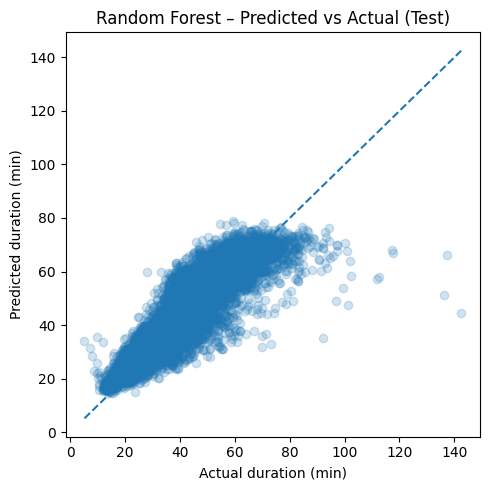

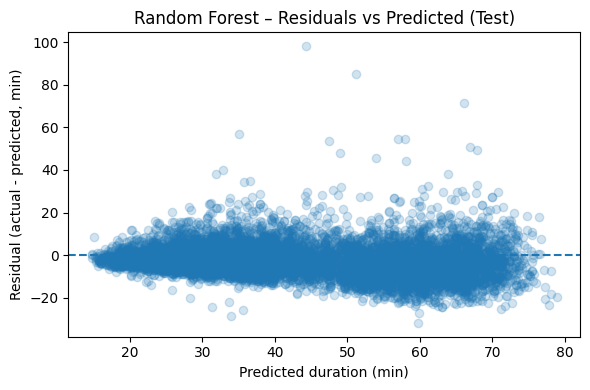

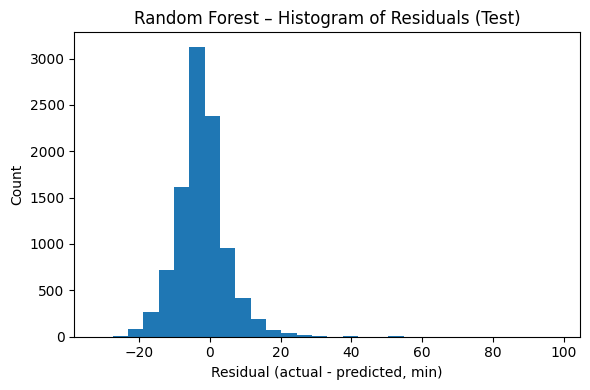

In [26]:
# Test-set visuals for Random Forest
plot_pred_vs_actual(y_reg_test, y_pred_rf_test, "Random Forest – Predicted vs Actual (Test)")
plot_residuals_vs_pred(y_reg_test, y_pred_rf_test, "Random Forest – Residuals vs Predicted (Test)")
plot_residual_hist(y_reg_test, y_pred_rf_test, "Random Forest – Histogram of Residuals (Test)")

### Random Forest Feature Importance

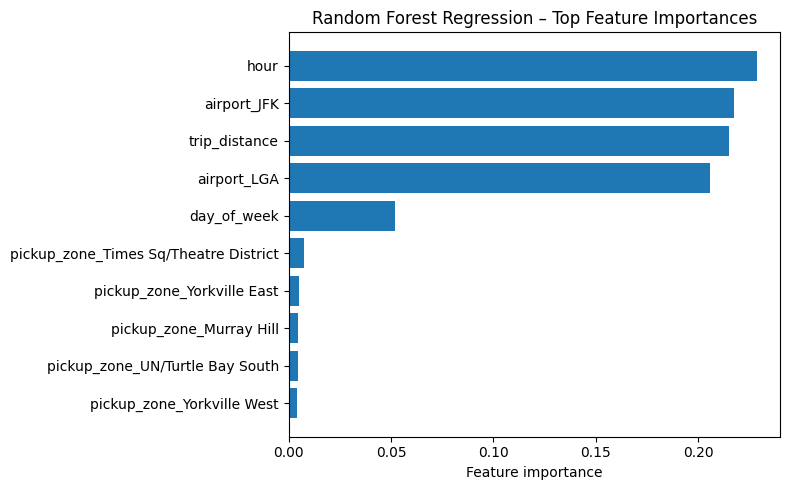

In [27]:
# Get feature names from preprocessor
ohee = best_rf_model.named_steps["pre"].named_transformers_["cat"]
cat_feature_names = ohee.get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features, cat_feature_names])

# Importances from XGB model
importances = best_rf_model.named_steps["model"].feature_importances_

k = 10
idx_sorted = np.argsort(importances)[::-1][:k]
top_feats = feature_names[idx_sorted]
top_imps  = importances[idx_sorted]

plt.figure(figsize=(8, 5))
plt.barh(range(len(top_feats)), top_imps)
plt.yticks(range(len(top_feats)), top_feats)
plt.gca().invert_yaxis()
plt.xlabel("Feature importance")
plt.title("Random Forest Regression – Top Feature Importances")
plt.tight_layout()
plt.show()

In [28]:
# Make a copy so we don't mess up the original
test_reg = test.copy()

# Add predictions for each regression model
test_reg["pred_lin"] = lin_reg_pipe.predict(X_test_reg)
test_reg["pred_rf"]  = best_rf_model.predict(X_test_reg)
test_reg["pred_xgb"] = best_xgb_reg.predict(X_test_reg) 

# Residuals (actual - predicted) and absolute error for each model
for name in ["lin", "rf", "xgb"]:
    test_reg[f"err_{name}"]     = test_reg["duration_min"] - test_reg[f"pred_{name}"]
    test_reg[f"abs_err_{name}"] = test_reg[f"err_{name}"].abs()

### Predictions by Zone + Airport

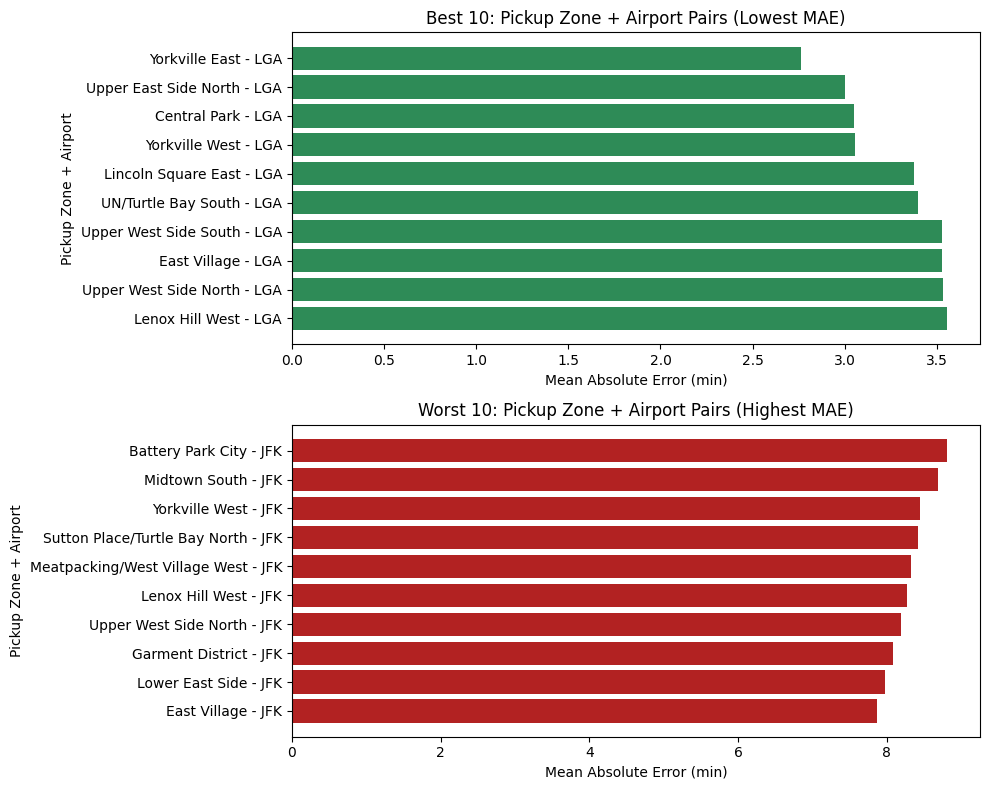

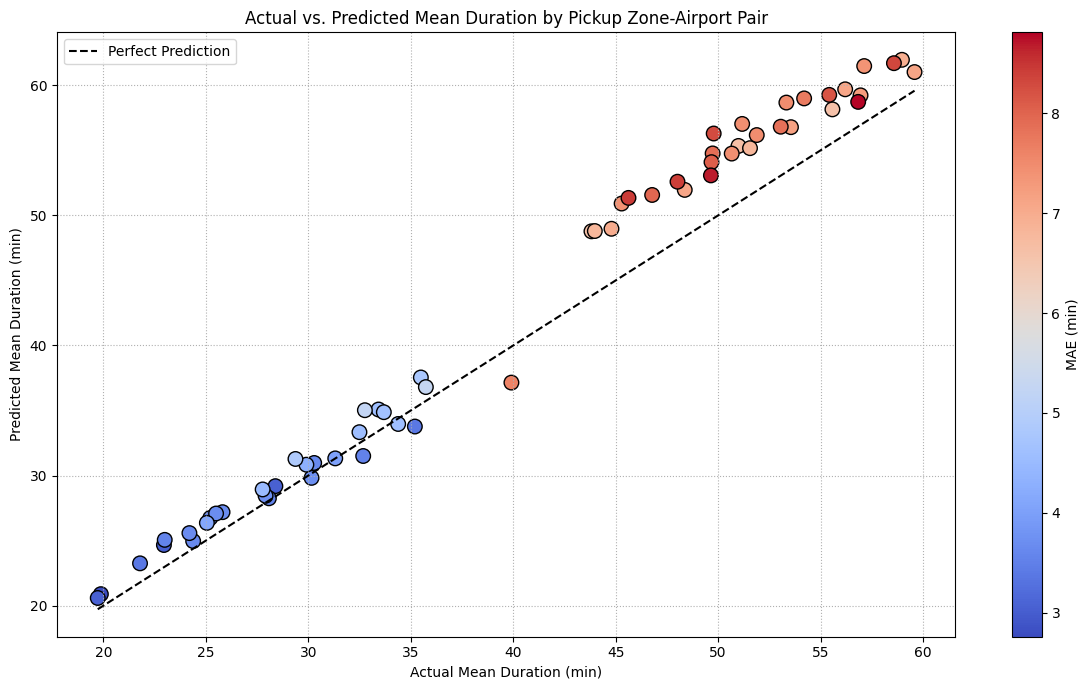

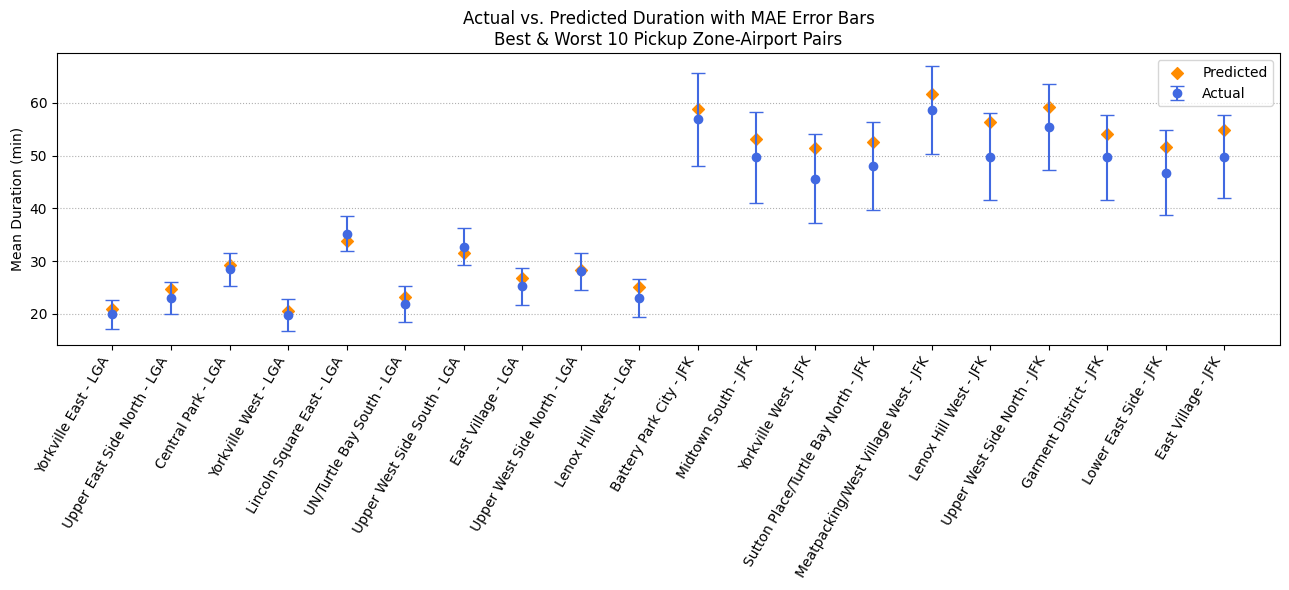

In [ ]:
zone_airport_summary = (test_reg.groupby(["pickup_zone", "airport"]).agg(
    n_trips = ("duration_min", "size"),
    actual_mean = ("duration_min", "mean"),
    pred_rf_mean = ("pred_rf", "mean"),
    mae_rf = ("abs_err_rf", "mean")
    )
    .reset_index())


# Filter to zones with enough trips and sort by error or time
zone_airport_summary = (zone_airport_summary.query("n_trips >= 50").sort_values("mae_rf"))
zone_airport_summary.head()


# Show the 10 pickup zone + airport combos with the lowest and highest MAE (model error)

# Best 10 (lowest error)
best10 = zone_airport_summary.nsmallest(10, "mae_rf")
# Worst 10 (highest error)
worst10 = zone_airport_summary.nlargest(10, "mae_rf")

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

# Best 10
axes[0].barh(
    best10["pickup_zone"] + " - " + best10["airport"], 
    best10["mae_rf"], 
    color="seagreen"
)
axes[0].set_title("Best 10: Pickup Zone + Airport Pairs (Lowest MAE)")
axes[0].set_xlabel("Mean Absolute Error (min)")
axes[0].set_ylabel("Pickup Zone + Airport")
axes[0].invert_yaxis()

# Worst 10
axes[1].barh(
    worst10["pickup_zone"] + " - " + worst10["airport"], 
    worst10["mae_rf"], 
    color="firebrick"
)
axes[1].set_title("Worst 10: Pickup Zone + Airport Pairs (Highest MAE)")
axes[1].set_xlabel("Mean Absolute Error (min)")
axes[1].set_ylabel("Pickup Zone + Airport")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()



# Enhanced visualizations:
import seaborn as sns

# Scatter plot 
plt.figure(figsize=(12, 7))
sc = plt.scatter(
    zone_airport_summary["actual_mean"],
    zone_airport_summary["pred_rf_mean"],
    c=zone_airport_summary["mae_rf"],
    cmap="coolwarm", s=110, edgecolor="k"
)
plt.xlabel("Actual Mean Duration (min)")
plt.ylabel("Predicted Mean Duration (min)")
plt.title("Actual vs. Predicted Mean Duration by Pickup Zone-Airport Pair")
plt.plot([zone_airport_summary["actual_mean"].min(), zone_airport_summary["actual_mean"].max()],
         [zone_airport_summary["actual_mean"].min(), zone_airport_summary["actual_mean"].max()], 
         'k--', label="Perfect Prediction")
plt.colorbar(sc, label="MAE (min)")
plt.legend()
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()

# 3. Error bars
fig, ax = plt.subplots(figsize=(13,6))
x_labels = (
    list(best10["pickup_zone"] + " - " + best10["airport"]) +
    list(worst10["pickup_zone"] + " - " + worst10["airport"])
)
actual_means = list(best10["actual_mean"]) + list(worst10["actual_mean"])
predicted_means = list(best10["pred_rf_mean"]) + list(worst10["pred_rf_mean"])
mae_vals = list(best10["mae_rf"]) + list(worst10["mae_rf"])

x = range(len(x_labels))
ax.errorbar(x, actual_means, yerr=mae_vals, fmt='o', label='Actual', color='royalblue', capsize=5)
ax.scatter(x, predicted_means, label='Predicted', color='darkorange', marker='D')
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=60, ha='right')
ax.set_ylabel("Mean Duration (min)")
ax.set_title("Actual vs. Predicted Duration with MAE Error Bars\nBest & Worst 10 Pickup Zone-Airport Pairs")
ax.legend()
ax.grid(axis='y', linestyle=':')
plt.tight_layout()
plt.show()

### Prediction by Hour of Day

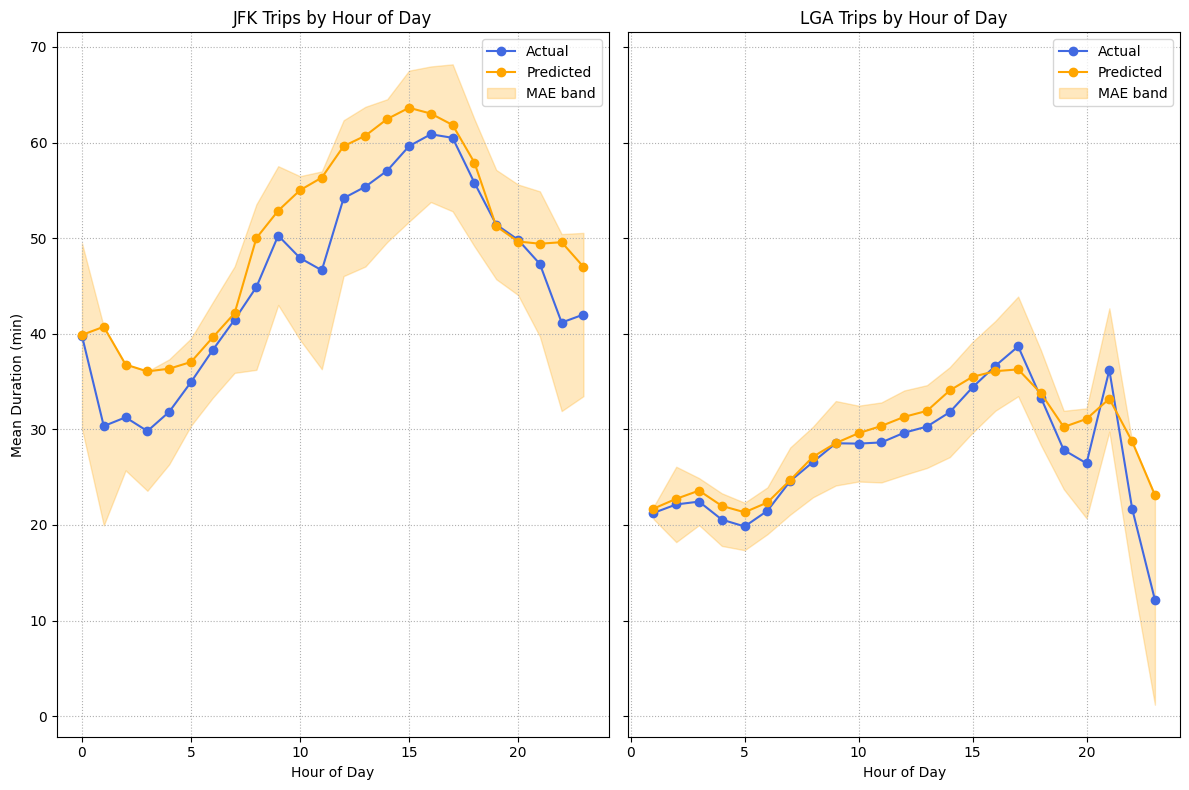

In [32]:
hour_airport_summary = (test_reg.groupby(["hour", "airport"]).agg(
    n_trips = ("duration_min", "size"),
    actual_mean = ("duration_min", "mean"),
    pred_rf = ("pred_rf", "mean"),
    mae_rf = ("abs_err_rf", "mean")
    )
    .reset_index()
    .sort_values(["airport", "hour"]))

hour_airport_summary.head(39)

fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharey=True)

# Plot for JFK
hour_airport_summary_jfk = hour_airport_summary[hour_airport_summary['airport'] == 'JFK']
axes[0].plot(hour_airport_summary_jfk['hour'], hour_airport_summary_jfk['actual_mean'], label='Actual', color='royalblue', marker='o')
axes[0].plot(hour_airport_summary_jfk['hour'], hour_airport_summary_jfk['pred_rf'], label='Predicted', color='orange', marker='o')
axes[0].fill_between(
    hour_airport_summary_jfk['hour'],
    hour_airport_summary_jfk['actual_mean'] - hour_airport_summary_jfk['mae_rf'],
    hour_airport_summary_jfk['actual_mean'] + hour_airport_summary_jfk['mae_rf'],
    color='orange', alpha=0.25, label='MAE band'
)
axes[0].set_title("JFK Trips by Hour of Day")
axes[0].set_xlabel("Hour of Day")
axes[0].set_ylabel("Mean Duration (min)")
axes[0].legend()
axes[0].grid(True, linestyle=':')

# Plot for LGA
hour_airport_summary_lga = hour_airport_summary[hour_airport_summary['airport'] == 'LGA']
axes[1].plot(hour_airport_summary_lga['hour'], hour_airport_summary_lga['actual_mean'], label='Actual', color='royalblue', marker='o')
axes[1].plot(hour_airport_summary_lga['hour'], hour_airport_summary_lga['pred_rf'], label='Predicted', color='orange', marker='o')
axes[1].fill_between(
    hour_airport_summary_lga['hour'],
    hour_airport_summary_lga['actual_mean'] - hour_airport_summary_lga['mae_rf'],
    hour_airport_summary_lga['actual_mean'] + hour_airport_summary_lga['mae_rf'],
    color='orange', alpha=0.25, label='MAE band'
)
axes[1].set_title("LGA Trips by Hour of Day")
axes[1].set_xlabel("Hour of Day")
axes[1].legend()
axes[1].grid(True, linestyle=':')

plt.tight_layout()
plt.show()


### Zone Model Performance 

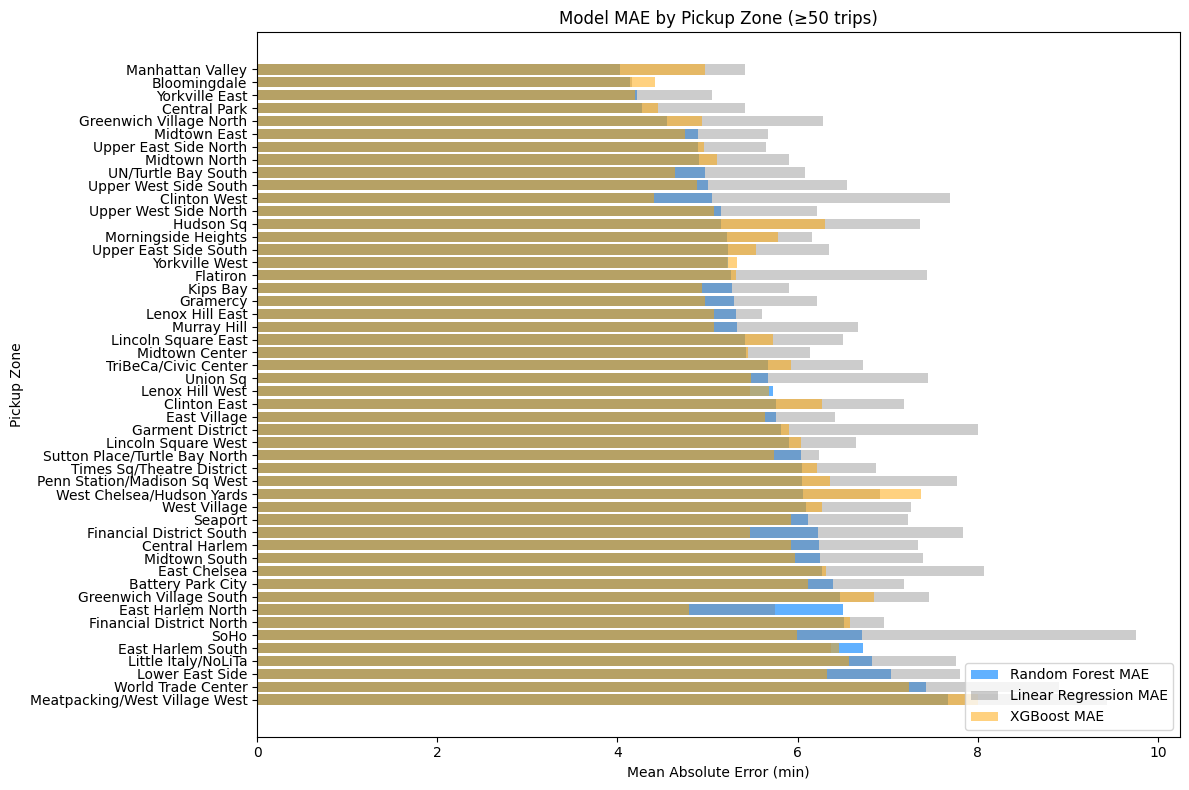

In [35]:
zone_model_perf = (test_reg.groupby("pickup_zone").agg(
    n_trips   = ("duration_min", "size"),
    mae_lin   = ("abs_err_lin", "mean"),
    mae_rf    = ("abs_err_rf", "mean"),
    mae_xgb   = ("abs_err_xgb", "mean")
    )
    .query("n_trips >= 25")
    .reset_index()
)

zone_model_perf.head(69)

#  Visualize Model Performance by Pickup Zone 

fig, ax = plt.subplots(figsize=(12,8))

zones_sorted = zone_model_perf.sort_values("mae_rf", ascending=False)

ax.barh(zones_sorted["pickup_zone"], zones_sorted["mae_rf"], color="dodgerblue", alpha=0.7, label="Random Forest MAE")
ax.barh(zones_sorted["pickup_zone"], zones_sorted["mae_lin"], color="gray", alpha=0.4, label="Linear Regression MAE")
ax.barh(zones_sorted["pickup_zone"], zones_sorted["mae_xgb"], color="orange", alpha=0.5, label="XGBoost MAE")

ax.set_xlabel("Mean Absolute Error (min)")
ax.set_ylabel("Pickup Zone")
ax.set_title("Model MAE by Pickup Zone (≥50 trips)")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

